### TabularExplainer for income prediction (classification)

The class `TabularExplainer` is designed for tabular data, acting as a factory of the supported tabular explainers such as LIME, SHAP and MACE. `TabularExplainer` provides a unified easy-to-use interface for all the supported explainers. In practice, we recommend applying `TabularExplainer` to generate explanations instead of using a specific explainer in the package `omnixai.explainers.tabular`.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import os
import sklearn
import sklearn.datasets
import sklearn.ensemble
import xgboost
import numpy as np
import pandas as pd

from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer
from omnixai.visualization.dashboard import Dashboard

The dataset used in this example is for income prediction (https://archive.ics.uci.edu/ml/datasets/adult). We recommend using `Tabular` to represent a tabular dataset that can be constructed from a pandas dataframe or a numpy array. To create a `Tabular` instance given a pandas dataframe, one needs to specify the dataframe, the categorical feature names (if exists) and the target/label column name (if exists). The package `omnixai.preprocessing` provides several useful preprocessing functions for a `Tabular` data. 

In [3]:
# Load the dataset
feature_names = [
    "Age", "Workclass", "fnlwgt", "Education",
    "Education-Num", "Marital Status", "Occupation",
    "Relationship", "Race", "Sex", "Capital Gain",
    "Capital Loss", "Hours per week", "Country", "label"
]
df = pd.DataFrame(
    np.genfromtxt(os.path.join('data', 'adult.data'), delimiter=', ', dtype=str),
    columns=feature_names
)
tabular_data = Tabular(
    data=df,
    categorical_columns=[feature_names[i] for i in [1, 3, 5, 6, 7, 8, 9, 13]],
    target_column='label'
)
print(tabular_data)

      Age         Workclass  fnlwgt   Education Education-Num  \
0      39         State-gov   77516   Bachelors            13   
1      50  Self-emp-not-inc   83311   Bachelors            13   
2      38           Private  215646     HS-grad             9   
3      53           Private  234721        11th             7   
4      28           Private  338409   Bachelors            13   
...    ..               ...     ...         ...           ...   
32556  27           Private  257302  Assoc-acdm            12   
32557  40           Private  154374     HS-grad             9   
32558  58           Private  151910     HS-grad             9   
32559  22           Private  201490     HS-grad             9   
32560  52      Self-emp-inc  287927     HS-grad             9   

           Marital Status         Occupation   Relationship   Race     Sex  \
0           Never-married       Adm-clerical  Not-in-family  White    Male   
1      Married-civ-spouse    Exec-managerial        Husband  Wh

`TabularTransform` is a special transform designed for tabular data. By default, it converts categorical features into one-hot encoding, and keeps continuous-valued features (if one wants to normalize continuous-valued features, set the parameter `cont_transform` in `TabularTransform` to `Standard` or `MinMax`). The `transform` method of `TabularTransform` will transform a `Tabular` instance into a numpy array. If the `Tabular` instance has a target/label column, the last column of the transformed numpy array will be the target/label. 

If some other transformations that are not supported in the library are necessary, one can simply convert the `Tabular` instance into a pandas dataframe by calling `Tabular.to_pd()` and try different transformations with it.

After data preprocessing, we can train a XGBoost classifier for this task (one may try other classifiers). 

In [4]:
# Train an XGBoost model
np.random.seed(1)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)
train, test, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
gbtree.fit(train, train_labels)
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(test_labels, gbtree.predict(test))))

# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

Training data shape: (26048, 108)
Test data shape:     (6513, 108)
Test accuracy: 0.8668816213726394


To initialize `TabularExplainer`, we need to set the following parameters:

  - `explainers`: The names of the explainers to apply, e.g., ["lime", "shap", "mace", "pdp"].
  - `data`: The data used to initialize explainers. ``data`` is the training dataset for training the machine learning model. If the training dataset is too large, ``data`` can be a subset of it by applying `omnixai.sampler.tabular.Sampler.subsample`.
  - `model`: The ML model to explain, e.g., a scikit-learn model, a tensorflow model, a pytorch model or a black-box prediction function.
  - `preprocess`: The preprocessing function converting the raw data (a `Tabular` instance) into the inputs of `model`.
  - `postprocess` (optional): The postprocessing function transforming the outputs of ``model`` to a user-specific form, e.g., the predicted probability for each class. The output of `postprocess` should be a numpy array.
  - `mode`: The task type, e.g., "classification" or "regression".
  

The preprocessing function takes a `Tabular` instance as its input and outputs the processed features that the ML model consumes. In this example, we simply call `transformer.transform`. If one uses some special transforms on pandas dataframes, the preprocess function has this kind of format: `lambda z: some_transform(z.to_pd())`.

In [5]:
preprocess = lambda z: transformer.transform(z)

We are now ready to create a `TabularExplainer`. `params` in `TabularExplainer` allows us to set parameters for each explainer applied here. For example, "kernel_width" for LIME is set to 3. 

In this example, LIME, SHAP and MACE generate local explanations while PDP (partial dependence plot) generates global explanations. `explainers.explain` returns the local explanations generated by the three methods given the test instances, and `explainers.explain_global` returns the global explanations generated by PDP. `TabularExplainer` hides all the details behind the explainers, so we can simply call these two methods to generate explanations.

In [6]:
# Initialize a TabularExplainer
explainers = TabularExplainer(
    explainers=["lime", "shap", "mace", "pdp"],
    mode="classification",
    data=train_data,
    model=gbtree,
    preprocess=preprocess,
    params={
        "lime": {"kernel_width": 3},
        "shap": {"nsamples": 100},
        "mace": {"ignored_features": ["Sex", "Race", "Relationship", "Capital Loss"]}
    }
)
# Generate explanations
test_instances = test_data[1653:1658]
local_explanations = explainers.explain(X=test_instances)
global_explanations = explainers.explain_global(
    params={"pdp": {"features": ["Age", "Education-Num", "Capital Gain",
                                 "Capital Loss", "Hours per week", "Education",
                                 "Marital Status", "Occupation"]}}
)

  0%|          | 0/5 [00:00<?, ?it/s]

`ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance to plot, e.g., `index = 0` means plotting the first instance in `test_instances`.

LIME results:


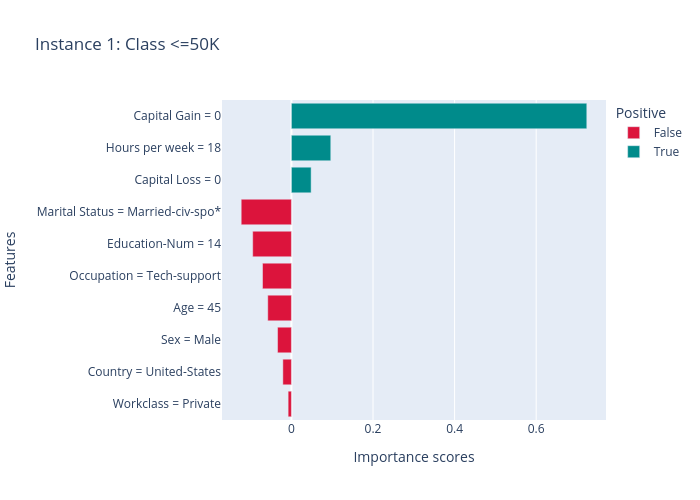

SHAP results:


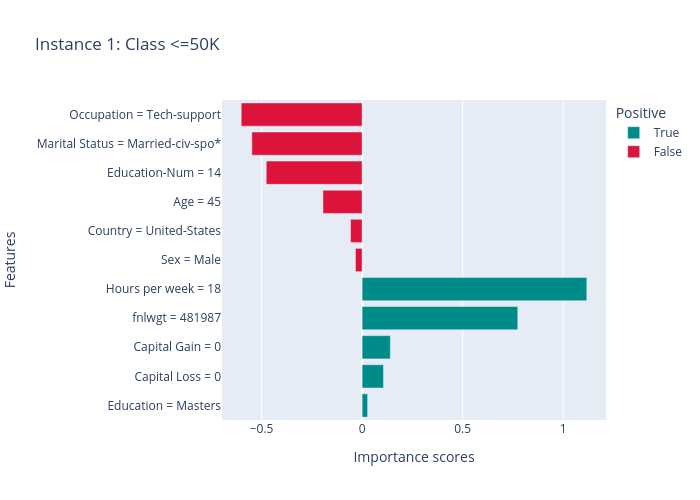

MACE results:


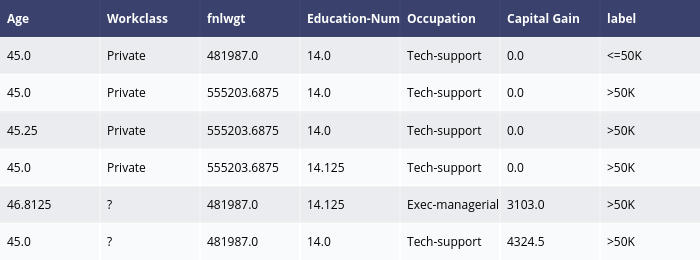

PDP results:


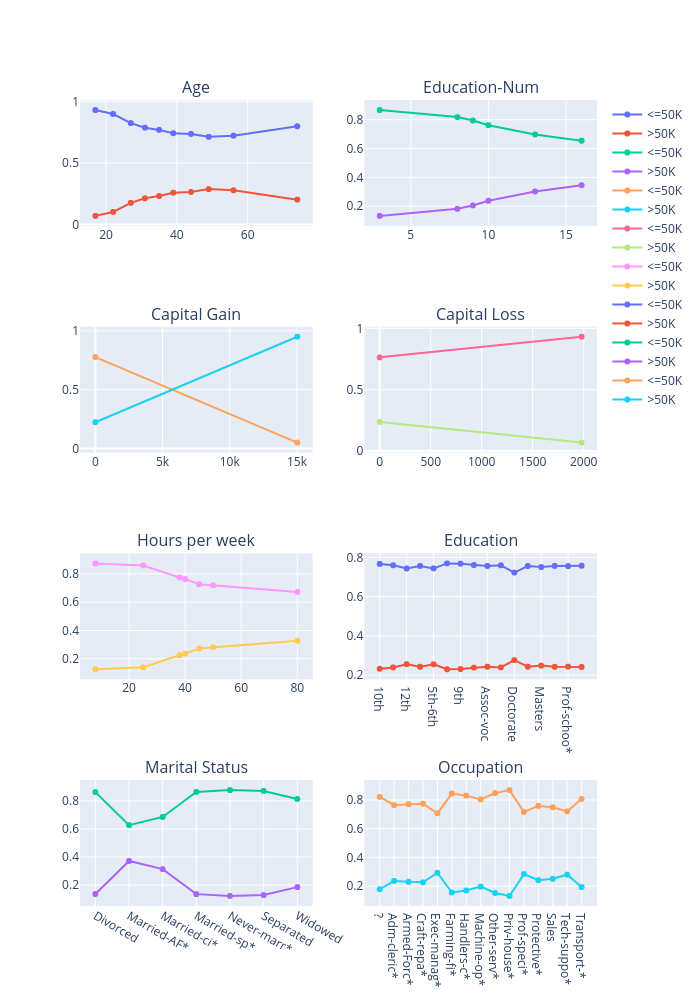

In [7]:
index=1
print("LIME results:")
local_explanations["lime"].ipython_plot(index, class_names=class_names)
print("SHAP results:")
local_explanations["shap"].ipython_plot(index, class_names=class_names)
print("MACE results:")
local_explanations["mace"].ipython_plot(index, class_names=class_names)
print("PDP results:")
global_explanations["pdp"].ipython_plot(class_names=class_names)

Similarly, we create a `PredictionAnalyzer` for computing performance metrics for this classification task. To initialize `PredictionAnalyzer`, we set the following parameters:

  - `mode`: The task type, e.g., "classification" or "regression".
  - `test_data`: The test dataset, which should be a `Tabular` instance.
  - `test_targets`: The test labels or targets. For classification, ``test_targets`` should be integers (processed by a LabelEncoder) and match the class probabilities returned by the ML model.
  - `preprocess`: The preprocessing function converting the raw data (a `Tabular` instance) into the inputs of `model`.
  - `postprocess` (optional): The postprocessing function transforming the outputs of ``model`` to a user-specific form, e.g., the predicted probability for each class. The output of `postprocess` should be a numpy array.

In [8]:
# Compute metrics
from omnixai.explainers.prediction import PredictionAnalyzer

analyzer = PredictionAnalyzer(
    mode="classification",
    test_data=test_data,
    test_targets=test_labels,
    model=gbtree,
    preprocess=preprocess
)
prediction_explanations = analyzer.explain()

The `explain` method returns a dict containing multiple metrics:

metric:


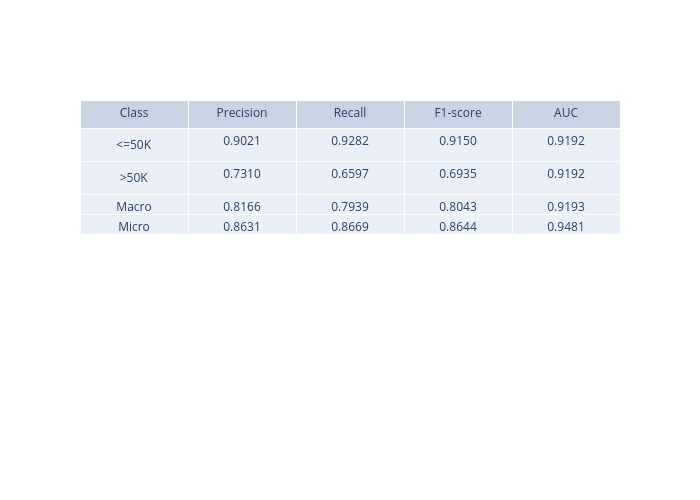

confusion_matrix:


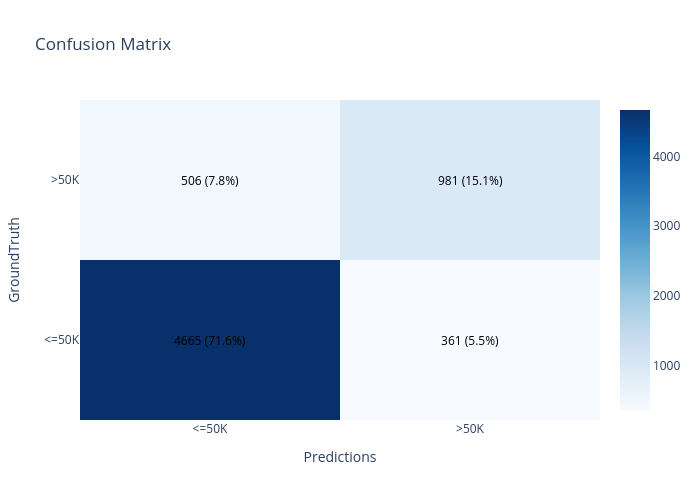

roc:


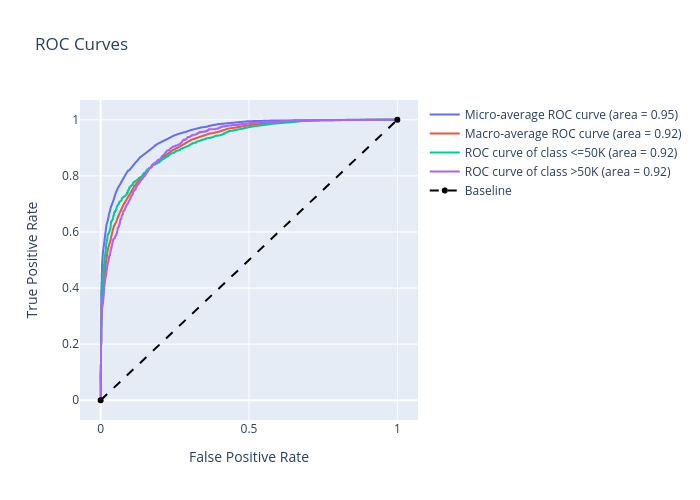

precision_recall:


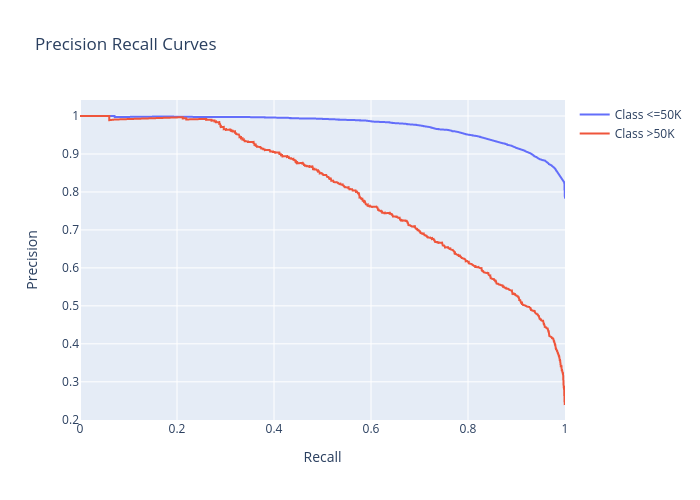

cumulative_gain:


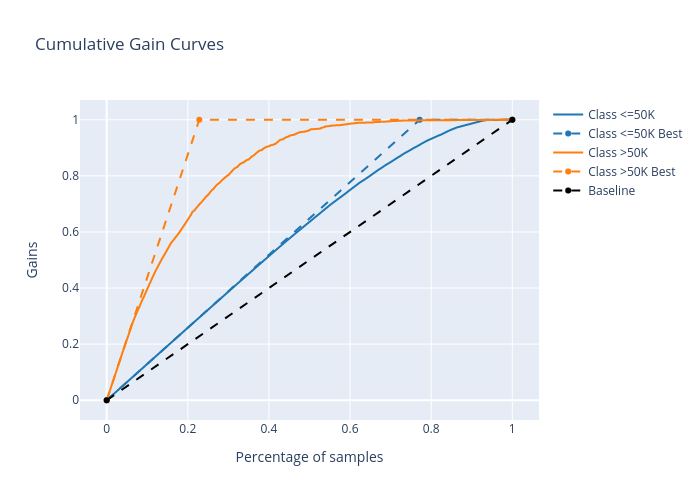

lift_curve:


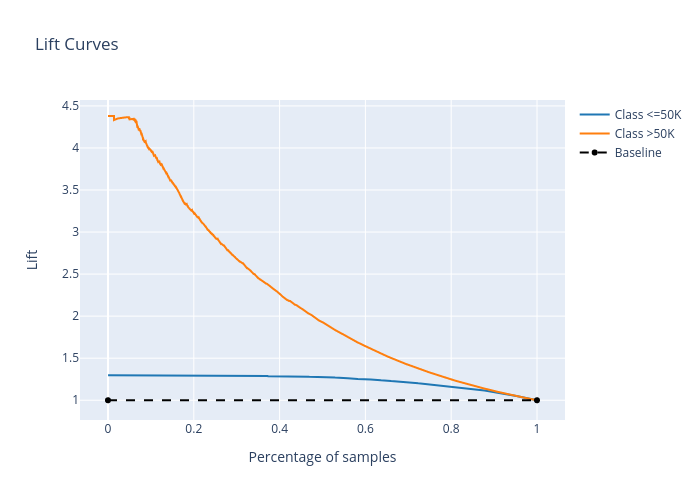

In [9]:
for name, metrics in prediction_explanations.items():
    print(f"{name}:")
    metrics.ipython_plot(class_names=class_names)

Given the generated explanations, we can launch a dashboard (a Dash app) for visualization by setting the test instance, the local explanations, the global explanations, the prediction result analysis, the class names, and additional parameters for visualization (optional).

In [10]:
# Launch a dashboard for visualization
dashboard = Dashboard(
    instances=test_instances,
    local_explanations=local_explanations,
    global_explanations=global_explanations,
    prediction_explanations=prediction_explanations,
    class_names=class_names
)
dashboard.show()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "omnixai.visualization.dashboard" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
